In [1]:
import os
import sys
sys.path.append("../")
from concerto_function5_3 import *
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
#Select an available GPU to run on a multi-GPU computer or you can run it directly on the CPU without executing this cell
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '7' 
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# test
You can use our TF-record and weight to reproduce attention weight and you can also use your own generated TF-record and trained weight.
If you use the tfrecord generated by yourself for testing, you can set the number of samples (n_cells_for_sample) to 10000,20000, etc. If you use our TF-record, please set n_cells_for_sample to None.


In [2]:
save_path = './tfrecord_multimodal/'
weight_path = './weight/'
RNA_tf_path = save_path + 'RNA/'
Protein_tf_path = save_path + 'Protein/'
saved_weight_path = './saved_weight/multimodal_weight.h5'# You can choose a trained weight or use None to default to the weight of the last epoch.
embedding,batch,RNA_id,attention_weight =  concerto_test_multimodal(weight_path,RNA_tf_path,Protein_tf_path,n_cells_for_sample = None,super_parameters={'batch_size': 128, 'epoch_pretrain': 1, 'lr': 1e-4,'drop_rate': 0.1},saved_weight_path = saved_weight_path)

load saved weight
/data/CXxie_data/workspace/github_concerto/codeocean_upload/PBMC160K_unsupervised/tfrecord/0523_divide/3/RNA/1_3.tfrecord
/data/CXxie_data/workspace/github_concerto/codeocean_upload/PBMC160K_unsupervised/tfrecord/0523_divide/3/Protein/1_3.tfrecord
feature_len: 1000000
all_samples num:128
all_samples num:256
all_samples num:384
all_samples num:512
all_samples num:640
all_samples num:768
all_samples num:896
all_samples num:1024
all_samples num:1152
all_samples num:1280
all_samples num:1408
all_samples num:1536
all_samples num:1664
all_samples num:1792
all_samples num:1920
all_samples num:2048
all_samples num:2176
all_samples num:2304
all_samples num:2432
all_samples num:2560
all_samples num:2688
all_samples num:2816
all_samples num:2944
all_samples num:3072
all_samples num:3200
all_samples num:3328
all_samples num:3456
all_samples num:3584
all_samples num:3712
all_samples num:3840
all_samples num:3968
all_samples num:4096
all_samples num:4224
all_samples num:4352
all_sa

In [3]:
adata_RNA = sc.read('./adata_RNA.h5ad')
adata_RNA_1 = adata_RNA[RNA_id]
adata_RNA_1.obsm['X_embedding'] = embedding

In [4]:
l2tol1 = {'CD8 Naive': 'CD8 T',
 'CD8 Proliferating': 'CD8 T',
 'CD8 TCM': 'CD8 T',
 'CD8 TEM': 'CD8 T',
 'CD4 CTL': 'CD4 T',
 'CD4 Naive': 'CD4 T',
 'CD4 Proliferating': 'CD4 T',
 'CD4 TCM': 'CD4 T',
 'CD4 TEM': 'CD4 T',
 'Treg': 'CD4 T',
 'NK': 'NK',
 'NK Proliferating': 'NK',
 'NK_CD56bright': 'NK',
 'dnT': 'other T',
 'gdT': 'other T',
 'ILC': 'other T',
 'MAIT': 'other T',
 'CD14 Mono': 'Monocytes',
 'CD16 Mono': 'Monocytes',
 'cDC1': 'DC',
 'cDC2': 'DC',
 'pDC': 'DC',
  'ASDC':'DC',
 'B intermediate': 'B',
 'B memory': 'B',
 'B naive': 'B',
 'Plasmablast': 'B',
 'Eryth': 'other',
 'HSPC': 'other',
 'Platelet': 'other'
}
adata_RNA_1.obs['cell_type_l1'] = adata_RNA_1.obs['cell_type'].map(l2tol1)

In [5]:
adata_RNA_1.obs['cell_type_l1'].value_counts()

CD4 T        4701
Monocytes    4066
NK           2410
CD8 T        1616
B             923
other T       461
DC            250
other          89
Name: cell_type_l1, dtype: int64

# plot attention

In [6]:
f = attention_weight
lv1_rna = f['attention_output_RNA']
lv1_protein = f['attention_output_Protein']
lv1_rna = np.squeeze(lv1_rna)
lv1_protein = -np.squeeze(lv1_protein)
adata_Protein = sc.read('./adata_Protein.h5ad')
gene_names = adata_RNA.var_names.tolist()
prot_names = adata_Protein.var_names.tolist()

In [7]:
N_sample_to_plot = 10000
r_ = np.random.choice(range(lv1_rna.shape[0]), size=N_sample_to_plot,replace=False)
lv1_rna_sub = lv1_rna[r_,:] 
lv1_prot_sub = lv1_protein[r_,:]
lv1_rna_sub = lv1_rna_sub.reshape((N_sample_to_plot, len(gene_names)))
adata1_RNA_unsup = sc.AnnData(X=lv1_rna_sub, obs=adata_RNA_1[r_].obs)
adata1_RNA_unsup.var_names = gene_names

lv1_prot_sub = lv1_prot_sub.reshape((N_sample_to_plot, len(prot_names)))
adata1_pro_unsup = sc.AnnData(X=lv1_prot_sub, obs=adata_RNA_1[r_].obs)
adata1_pro_unsup.var_names = prot_names

In [8]:
rna_varnames = adata1_RNA_unsup.var_names+'_RNA'
pro_varnames = adata1_pro_unsup.var_names+'_Protein'
concat_varnames = np.concatenate((rna_varnames,pro_varnames))
a = np.concatenate((adata1_RNA_unsup.X, adata1_pro_unsup.X), axis=1)
adata1_concat_unsup = sc.AnnData(X=a, obs=adata1_RNA_unsup.obs)
adata1_concat_unsup.var_names = concat_varnames

/home/CXxie/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_l1' as categorical


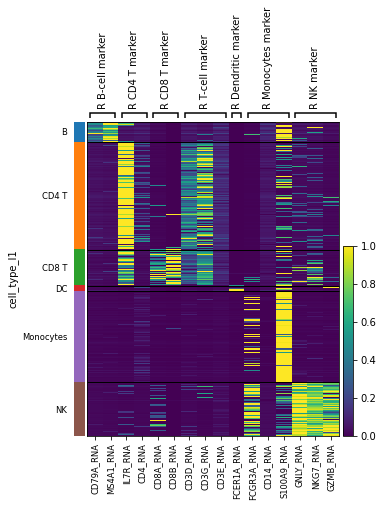

Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_l1' as categorical


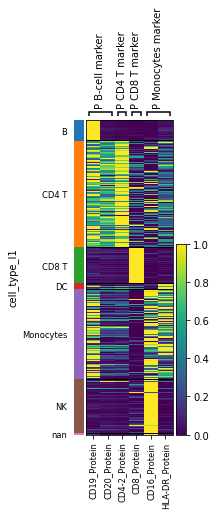

In [9]:
marker_genes_dict = {
    'R B-cell marker': ['CD79A_RNA', 'MS4A1_RNA'],
    'R CD4 T marker': ['IL7R_RNA','CD4_RNA'],
    'R CD8 T marker': ['CD8A_RNA','CD8B_RNA',],
    'R T-cell marker': ['CD3D_RNA','CD3G_RNA','CD3E_RNA'],
    'R Dendritic marker': ['FCER1A_RNA'],
    'R Monocytes marker': ['FCGR3A_RNA','CD14_RNA','S100A9_RNA'],
    'R NK marker': ['GNLY_RNA', 'NKG7_RNA','GZMB_RNA'],    
}

marker_prot_dict = {
    'P B-cell marker': ['CD19_Protein','CD20_Protein'],
    'P CD4 T marker': ['CD4-2_Protein'],
    'P CD8 T marker': ['CD8_Protein'],#CD8a_Protein
    'P Monocytes marker': ['CD16_Protein','HLA-DR_Protein'],
}
key_names = 'cell_type_l1'
mask = adata1_concat_unsup.obs[key_names].isin(['other T','other',np.nan])
sc.pl.heatmap(adata1_concat_unsup[~mask], marker_genes_dict, groupby=key_names, cmap='viridis', 
                   swap_axes=False,dendrogram=False, standard_scale='obs')

mask = adata1_concat_unsup.obs[key_names].isin(['other T','other'])
ax = sc.pl.heatmap(adata1_concat_unsup[~mask], marker_prot_dict, groupby=key_names, cmap='viridis', swap_axes=False,
               dendrogram=False, standard_scale='obs')